In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10'

import jax
import diffrax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

import MultiTreeGP.evaluators.SR_evaluator as evaluator
from MultiTreeGP.environments.SR_environments.vd_pol_oscillator import VanDerPolOscillator
from MultiTreeGP.genetic_programming import GeneticProgramming

key = jr.PRNGKey(0)

These device(s) are detected:  [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


# Generate data

In [2]:
def get_data(key, env, T, batch_size=20):
    x_key, noise_key = jr.split(key)
    x0s = env.sample_init_states(batch_size, x_key)
    noise_keys = jr.split(noise_key, batch_size)
    ts = jnp.arange(0, T, 0.2)

    def solve(env, ts, x0, noise_key):
        solver = diffrax.Dopri5()
        dt0 = 0.001
        saveat = diffrax.SaveAt(ts=ts)

        system = diffrax.ODETerm(env.drift) 

        sol = diffrax.diffeqsolve(system, solver, ts[0], ts[-1], dt0, x0, saveat=saveat, max_steps=2000, adjoint=diffrax.DirectAdjoint(), stepsize_controller=diffrax.PIDController(atol=1e-7, rtol=1e-7, dtmin=0.001))
        xs = sol.ys

        return xs

    xs = jax.vmap(solve, in_axes=[None, None, 0, 0])(env, ts, x0s, noise_keys)
    
    return x0s, ts, xs, noise_keys



init_key, data_key = jr.split(key)

env = VanDerPolOscillator(0, 0)

T = 20
x0s, ts, xs, noise_keys = get_data(data_key, env, T=T, batch_size=16)

## Visualize trajectories

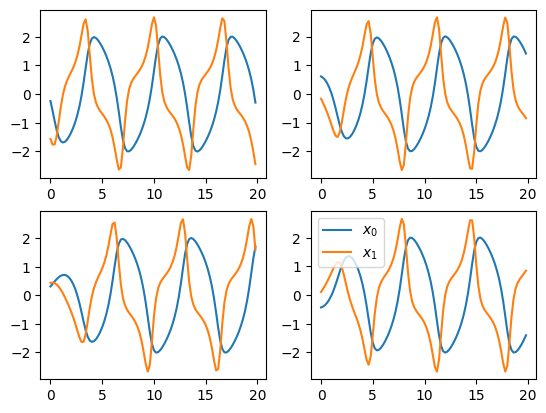

In [3]:
fig, ax = plt.subplots(2,2)
ax = ax.ravel()
for i in range(4):
    for j in range(env.n_var):
        ax[i].plot(ts, xs[i,:,j],color=f"C{j}", label=f"$x_{j}$")
plt.legend()
plt.show()

# Symbolic Regression

In [4]:
#Define hyperparameters
population_size = 100
num_populations = 10
num_generations = 100

#Define expressions
layer_sizes = jnp.array([2])

#Define evaluator
fitness_function = evaluator.Evaluator(solver=diffrax.Dopri5(), dt0 = 0.01, stepsize_controller=diffrax.PIDController(atol=1e-6, rtol=1e-6, dtmin=0.001), max_steps=500)

operator_list = [("+", lambda x, y: jnp.add(x, y), 2, 0.5), 
                 ("-", lambda x, y: jnp.subtract(x, y), 2, 0.1),
                 ("*", lambda x, y: jnp.multiply(x, y), 2, 0.5),
                 ("/", lambda x, y: jnp.divide(x, y), 2, 0.1)
                 ]

variable_list = [["x" + str(i) for i in range(env.n_var)]]

In [5]:
#Initialize strategy
strategy = GeneticProgramming(num_generations, population_size, fitness_function, operator_list, variable_list, layer_sizes, num_populations = num_populations)

#Initialize population
population = strategy.initialize_population(init_key)

for g in range(num_generations):
    fitness, population = strategy.evaluate_population(population, (x0s, ts, xs, noise_keys))
    
    if (g+1)%5==0:
        best_fitness, best_solution = strategy.get_statistics(g)
        
        print(f"In generation {g+1}, best fitness = {best_fitness:.4f}, best solution = {strategy.to_string(best_solution)}")

    if g < (num_generations-1):
        key, sample_key = jr.split(key)
        population = strategy.evolve(population, fitness, sample_key)

best_fitnesses, best_solutions = strategy.get_statistics()

Input data should be formatted as: ['x0', 'x1'].
In generation 5, best fitness = 2.1709, best solution = [x1, -0.81*x0]
In generation 10, best fitness = 2.0020, best solution = [0.94*x1 - 0.2936, -x0 - 0.2142]
In generation 15, best fitness = 1.4823, best solution = [x1, -0.92512*x0]
In generation 20, best fitness = 1.2039, best solution = [x1, -0.72*x0*(-x0 - 0.45)*(0.0453128824512*x0 + 0.0226564412256*x1) - x0]
In generation 25, best fitness = 1.1021, best solution = [-0.09*x1*(-0.95*x0 - 0.16) + x1, 0.048*x0*(-x0 - 0.2652)*(0.137904*x0**2 - x0) - x0]
In generation 30, best fitness = 1.0717, best solution = [-0.09*x1*(1.0036*x1 + 0.249784) + x1, 0.03*x0*(0.24 - x0)*(-0.104*x0**2*(0.24 - x0)**2 - x0) - x0]
In generation 35, best fitness = 0.8613, best solution = [x1 - (0.25 - 0.95*x0)*(0.09*x1*(0.03 - x1) + 0.09), -0.0350208*x0**2*(0.15*x0**2 - x0) - x0]
In generation 40, best fitness = 0.8566, best solution = [x1 - (0.09*x1*(0.03 - x1) + 0.09)*(-0.95*x0 + 0.09*x1 + 0.16), -0.0350208*

# Visualize best solution

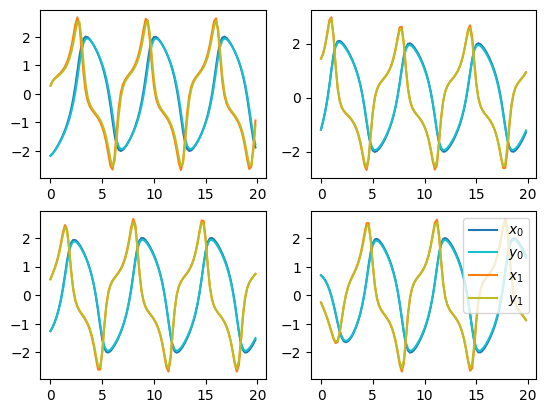

In [6]:
#Generate test data
x0s, ts, xs, noise_keys = get_data(jr.PRNGKey(42), env, T=T, batch_size=4)

#Evaluate best candidate on test data
fitness, pred = fitness_function.evaluate_candidate(best_solutions[-1], (x0s, ts, xs, noise_keys), strategy.vmap_foriloop)

fig, ax = plt.subplots(2,2)
ax = ax.ravel()
for i in range(4):
    for j in range(env.n_var):
        ax[i].plot(ts, xs[i,:,j],color=f"C{j}", label=f"$x_{j}$")
        ax[i].plot(ts, pred[i,:,j],color=f"C{9-j}", label=f"$y_{j}$")
plt.legend()
plt.show()